# Deep Q Network (DQN)

When moving on from discrete environments, such as grid world or black jack, the amount of state in a continous environment renders traditional tabular methods (Monte Carlo and TD learning) intractable (at least without any modification to the problem formulation). DQN method addresses this problem by using a value function approximator, essentially replacing the Q-table of explicit state-action value with a parameterized function $q^\pi_{\vec w}(s,a,\vec w)$. The vector $\vec w$ stores the weights or parameters of this approximating function.

The motivation of using value function approximator is clear, but where does it fit into the RL picture?
- Value function approximator is a direct mapping between the states (features) to the state-action value $Q(s,\cdot)$ 
- As such, the approximator function fits in the policy evaluation step of the RL training process. We train this function by minimizing the loss between the approximated value function and the actual value function $ s.t. \enspace q^\pi_{\vec w}(s,a,\vec w) \approx q^*$
- However, the true action value function $q^*$ is unknown and must be learnt from the interaction between the agent and its environment. We must employ Q-learning to approximate the true action value function, toward which we will update the parameterized value function $q^\pi_{\vec w}(s,a,\vec w)$. The update is as follow

**The DQN algorithm**
1. From a state $s$, take action $a$ using $\epsilon$-greedy policy, observe the reward $r$ and next state $s'$
2. Store the transition tuple $(s, a, r, s')$ in a replay memory $\mathcal{D}$. This replay memory is a buffer that stores the most recent transition tuples
3. From this replay memory, sample batches of $(s_t, a_t, r_{t+1}, s_{t+1})$ randomly for training the Q-function approximator
4. Adjust the parameters $\vec w$ by optimizing the mean squared error (MSE) between the Q network and the Q-learning target using Q-learning
$$ \mathcal{L}_i (\vec w_i) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}} \bigg[ \Big(r + \gamma \max_{a'}Q(s',a',\vec w^-_i) - Q(s,a,\vec w_i) \Big)^2\bigg]$$ 

When applying stochastic gradient descent, the update at every step is reduced as follows (the math found in the GoodNote notebook):

$$\Delta \vec w = \alpha \Big(r + \gamma \max_{a'} \underbrace{Q(s', a', \vec{w}_i^-)}_{\text{target}} - \underbrace{Q(s,a,\vec w_i)}_{\text{behaviour}} \Big) \vec x(s,a)$$


**Notes:** 

There are two mechanisms introduced in this paper that allow for stable training, one is experience replay, and the other is training two separate methods.
- **Experience replay** - this decorrelates the experience tuples (s,a,r,s') thus follow the i.i.d assumption for training a neural network
- **Two Q-networks**, a target network and a behaviour network. The parameters $\vec w'$ of the target network $Q(s,a,\vec w')$ are only updated infrequently to maintain a stable target. The parameters $\vec w$ of the behaviour network $Q(s,a,\vec w)$ are updated every policy improvement iteration to move toward this target network. The frequency of updating the target network is annother hyperparameter to tune. 

## Question to self
1. What does it mean to apply stochastic gradient descent to simplify the loss function? What are the implications?
- Every policy evaluation iteration, a random sample, or batch of samples, is used for updating the state-action value instead of every single experience stored in the replay buffer. Recall that the random sampling from the replay buffer de-correlates the experience and enforces the i.i.d. assumption
- SGD is used on a small batch of sample to reduce the variance inherent in the different experience in the replay buffer. Despite the noise and bias of this method, the performance of the Q networks improves.


</br>

2. Would it be beneficial to formulate the Q network such that the input is the state vector and the outputs are the Q-values associated with each possible action from the state. As such, one can just take the max value from the target Q network and index into the behaviour network for the corresponding action a?
- That is the common approach for approximating the action value function, outputting Q(s) for all a, then grabbing the maximum value
 
</br>

3. At first do I have to run the agent several times using the initial $\epsilon$-greedy policy to fill the memory buffer with training samples?
- Yes, and then pop in new experience at the end, push the oldest experience in the replay buffer out.

</br>

4. How often does the behaviour target network updated?

- At every step in an episode of the training process, the behaviour network is used for two different purposes:
    - Firstly, the behaviour network governs the trajectory of the agent at every step. 
    - Secondly, the behaviour Q network is used to predict (or infer) the action value for the <s,a> pairs drawn from a batch of experience (s,a,r,s'). These value is compared to the discounted maximum action value at state s', $\max Q(s',\cdot)$, according to the **target network**. 

- The behaviour network prediction of $Q(s,a)$ and the target network's label output of $r+\gamma \max Q(s',a')$ are used to compute a loss function. The gradient of this loss function is used for adjusting the parameters of the behaviour network.
- After the agent has taken a number of step, the parameters (or weights) or the behaviour network is loaded onto the target network.

</br>

5. How can I scale this environment up to have continuous action instead of just left/right?
- To my understanding, actuating the cart to the left or right at similar output level (voltage) at instantaneous moments throughout the control process is good enough for modulating the speed of the cart. Think of PWMs where the voltage is just switch at a certain duty cycle to simulate different voltage level.
- It is possible to have continuous action space. Since the Q network output is the state-action value Q(s,a) at each state s and action a, we know how good each action is in a state. The Q values can then be transformed into a proportional constant to control how much to move left or right (instead of just a binary left/right). This essentially means that the Q-value output of this network is not simply used for selecting the maximizing action at each state but also for governing the magnitude of cart actuation.


In [ ]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
import numpy as np

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

In [ ]:
# Simulate several episodes of the cart pole environment (random policy on a human render mode)
env = gym.make("CartPole-v1", render_mode = "human")

state, _ = env.reset(); t = 1
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, term, trunc, info = env.step(action)
    print(f"Time {t:2d}  |  s_t {state}  |  a_t {action:2d}  |  s_t+1 {next_state}  |  reward {reward:.2f}  |  terminated {term:2}  |  {info}")
    state = next_state; t += 1
    if term or trunc:
        break

In [ ]:
# Constant definitions
LR = 1e-3
BUFFER_SIZE = 5000                  # size of the experience replay buffer
MIN_REPLAY_SIZE = 1000              # The number of experience to sample before starting training
TARGET_UPDATE_FREQ = 1000           # the number of steps before updating the target network

GAMMA = 0.95                        # Discount factor for return calculation
EPSILON_START = 1.0                 # exploration rate in stochastic policy
EPSILON_END = 0.1                   # minimum exploration rate at the end of decay
EPSILON_DECAY = 5000                # epsilon decay rate

EPISODE_TRAIN = 5000              # number of episodes to train the Q-network
BATCH_SIZE = 32

In [ ]:
# Define Q-network architecture
class QNetwork(nn.Module):
    ''' A QNetwork class that initialize an MLP neural Q network with two hidden layers, each with 128 nodes '''
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)                       # The regression output are the state values of Q(s,a=left) and Q(s,a=right)

In [ ]:
# Dynamically define Q-network architecture

In [ ]:
# Initialize the environment and the Q network

env = gym.make("CartPole-v1")
state_space = env.observation_space.shape[0]        # State space of cart pos & vel, and pendulum angular pos and vel. Each component is a continuous value
action_space =  env.action_space.n                   # Action space of left or right

q_network = QNetwork(state_space,action_space)
target_network = QNetwork(state_space,action_space)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()                               # target network is only used for evaluation/inference and not trained

optimizer = optim.SGD(q_network.parameters(), lr = LR)
replay_buffer = deque(maxlen=BUFFER_SIZE)

In [ ]:
# Fill replay buffer with some initial samples for training (random policy)
obs, _ = env.reset()
for _ in range(MIN_REPLAY_SIZE):
    action = env.action_space.sample()
    next_obs, reward, term, trunc, _ = env.step(action)
    done = term or trunc

    replay_buffer.append((obs, action, reward, next_obs, done))
    obs = next_obs if not done else env.reset()[0]

In [ ]:
# DQN Model Training loop
reward_history = np.zeros(EPISODE_TRAIN)
epsilon = EPSILON_START
step_count = 0
target_network_update_count = 0

for episode in range(EPISODE_TRAIN):
    obs, _ = env.reset()
    eps_rewards = 0
    

    while True:
        # Epsilon-greedy policy to select action
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():       # Doing inference so no need to track operations
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
                q_values = q_network(state_tensor)
                action = q_values.argmax().item()                   # index of the maximum output (action)
        
        # Interact with the environment
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc
        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs
        eps_rewards += reward
        step_count += 1

        # Sample a batch and update the network
        if len(replay_buffer) >= BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(states)                                          # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
            actions = torch.LongTensor(actions).unsqueeze(1)                            # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Compute targets using target network Q(s',a',w_i^-)
            with torch.no_grad():
                target_q_values = target_network(next_states)                           # Find a batch of Q(s',a',w_i^-) from the batch of next_states
                max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                targets = rewards + GAMMA * max_target_q_values * (1 - dones)           # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states

            # Compute the current Q values for the actions taken Q(s,a,w_i)
            q_values = q_network(states).gather(1, actions)                             # obtain the q_values associated to the actual action taken in each sample

            # Update the parameters of the behaviour q_network
            loss = nn.MSELoss()(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             # Periodically update the target network
            if step_count % TARGET_UPDATE_FREQ == 0:
                target_network_update_count += 1
                target_network.load_state_dict(q_network.state_dict())

        if done:
            break
    
   
    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon - (EPSILON_START - EPSILON_END)/EPSILON_DECAY)

    reward_history[episode] = eps_rewards
    print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
    print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

env.close()

In [ ]:
# Helper function for EMA filters and plotting data
def EMA_filter(reward: list, alpha):
    ''' Function that runs an exponential moving average filter along a datastream '''
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

def plot_reward_hist(reward_history: list, hyperparam_config: str, save_path = None, alpha = 0.1):
    ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
    n_episodes= len(reward_history)
    episodes = range(n_episodes)
    filtered_reward_hist = EMA_filter(reward_history, alpha)

    plt.figure(figsize=(20,6))
    plt.plot(episodes, reward_history[:n_episodes], color = "blue")
    plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
    plt.title(f'Total reward per episode - {hyperparam_config}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(['Total reward','Filtered reward'])

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path,'reward_history.png'))
    plt.show()

In [ ]:
# Visualize the history of success rate
import matplotlib.pyplot as plt

episode = range(EPISODE_TRAIN)
filtered_reward_history = EMA_filter(reward_history, 0.1)

# Set figure size (width, height) in inches
plt.figure(figsize=(20, 6))

slice_idx = len(reward_history)
# Plot y1 vs x on the first subplot
plt.plot(episode[:slice_idx], reward_history[:slice_idx], color = "blue")
plt.plot(episode[:slice_idx], filtered_reward_history[:slice_idx], color = "red")
plt.title('Success Rate vs Traing Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(['Total reward', 'Filtered reward'])

# Adjust layout
plt.tight_layout()
plt.show()

## Save the trained model

In [ ]:
import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run

# Generate a timestamped directory for the training run
timestamp = datetime.now().strftime("%y%m%d_%H%M%S")
BASE_DIR = os.getcwd()
OUTPUT_DIR = os.path.join(BASE_DIR,f"inv_pend_results/{timestamp}_{EPISODE_TRAIN}_{BATCH_SIZE}_{LR}_{GAMMA}_{TARGET_UPDATE_FREQ}_{EPSILON_DECAY}")
os.makedirs(OUTPUT_DIR, exist_ok=True)

torch.save({
    'model_state_dict': q_network.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    
    'learning_rate': LR,
    'buffer_size': BUFFER_SIZE,
    'min_replay_size': MIN_REPLAY_SIZE,
    'target_update_freq': TARGET_UPDATE_FREQ,

    'gamma': GAMMA,
    'epsilon_start': EPSILON_START,
    'epsilon_end': EPSILON_END,
    'epsilon_decay': EPSILON_DECAY,

    'episode_train': EPISODE_TRAIN,
    'batch_size': BATCH_SIZE
}, os.path.join(OUTPUT_DIR,'q_network_checkpoint.pth'))

In [ ]:
checkpoint = torch.load("C:/Minh Nguyen/experiment/DRL/gym_exercise/inv_pend_results/250520_165708_5000_32_0.001_0.95_1000_5000/q_network_checkpoint.pth")
q_network_loaded = QNetwork(state_space,action_space)
q_network_loaded.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
print(checkpoint.keys())
print(checkpoint['optimizer_state_dict'].keys())

## Performance Visualization

Visualize the performance of the trained Q network in multiple simulations and observer the reward.

In [ ]:
env_test = gym.make("CartPole-v1", render_mode = "human")

# print(type(obs))
for episode in range(5):
    obs, _ = env_test.reset()
    done = False
    eps_reward = 0

    while not done:
        with torch.no_grad():       # Doing inference so no need to track operations
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()                   # index of the maximum output (action)
        
        next_obs, reward, term, trunc, _ = env_test.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

Visualize the state vs time plot

In [ ]:
import matplotlib.pyplot as plt

obs, _ = env_test.reset()
done = False
obs_history = []; obs_history.append(obs)
action_history = []
reward_history = []

while not done:
    with torch.no_grad():       # Doing inference so no need to track operations
        state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
        q_values = q_network(state_tensor)
        action = q_values.argmax().item()                   # index of the maximum output (action)
    
    next_obs, reward, term, trunc, _ = env_test.step(action)

    action_history.append(action)
    obs_history.append(next_obs)
    
    if not reward_history: reward_history.append(reward)
    else: reward_history.append(reward_history[-1] + reward)

    done = term or trunc
    obs = next_obs

# Convert obs_history to a NumPy array for easier slicing
obs_array = np.array(obs_history)

# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(12, 24), sharex=True)

# 1. Plot cumulative reward history
axs[0].plot(reward_history, label='Cumulative Reward', color='green')
axs[0].set_ylabel('Cumulative Reward')
axs[0].legend()
axs[0].grid(True)

# 2. Plot action history
axs[1].plot(action_history, label='Actions Taken', color='blue')
axs[1].set_ylabel('Action')
axs[1].legend()
axs[1].grid(True)

# 3. Plot each CartPole state variable over time
state_labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
for i in range(4):
    axs[i+2].plot(obs_array[:, i], label=state_labels[i])
    axs[i+2].set_ylabel('State Values')
    axs[i+2].set_xlabel('Timestep')
    axs[i+2].legend()
    axs[i+2].grid(True)

plt.tight_layout()
plt.show()


# Double DQN (DDQN)

This experiment is an extension of the previous experiment with DQN. Firstly, this experiment investigates the double DQN algorithm in an inverted pendulum experiment. Secondly, this experiment compares the computation time of various training setups
1. **OOP implementation** - one set of experiments using OOP with the DDQN_experiment class containing all training methods, and one set of experiment using explicit function calls (non OOP)
2. **CUDA computation** - one set of experiments with CUDA enabled, while CUDA is disabled in the other

<br>
With this, there are four experiments, namely
1. No OOP and no CUDA (nOOP_nCUDA) - simplest and most straightforward implementation of DDQN
2. No OOP and CUDA (nOOP_CUDA)
3. OOP and no CUDA (OOP_nCUDA)
4. OOP and CUDA (OOP_CUDA)

<br> <br>
**Experiment Metrics**

Each experiment set will be run for n times (n=100) to measure the amount of time to run (train + validate) each Q_net experiment. The average amount of time taken is used for deciding the optimal training setup for future research

In [ ]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import re
import os
import json
import time
import matplotlib.pyplot as plt

from datetime import datetime

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

In [ ]:
if torch.cuda.is_available():
    # device = torch.cuda.device()
    device_idx = torch.cuda.current_device()
    print(f"Number of GPU: {torch.cuda.device_count()}")
    print(f"Current device: {device_idx}|{torch.cuda.get_device_name(device_idx)}")

## Parameter definition

In [ ]:
# Meta parameters of the experiment
RESULTS_DIR = "comp_time_results"       # which experiment folder to save the training - "inv_pend_results" (DQN), "inv_pend_DDQN_result", or "comp_time_results"
VERBOSE = False                         # set to false to skip information prints and save computation time
NUM_RUN = 100                           # number of experiment to run collect training time and runtime
CUDA_ENABLED = False                    # whether to use CUDA computation acceleration

In [ ]:
# Hyperparameter definitions
MODEL_NAME = 'DQN_MLP_v0'
LR = 5e-4
BUFFER_SIZE = 5000              # size of the experience replay buffer
MIN_REPLAY_SIZE = 1000          # the number of experience to sample before starting training
TARGET_UPDATE_FREQ = 1000       # the number of steps before updating the target network

GAMMA = 0.95                    # discount factor for return calculation
EPS_START = 1.0                 # exploration rate in stochastic policy
EPS_END = 0.1                   # minimum exploration rate at the end of decay
EPS_DECAY = 5000                # epsilon decay rate

EPISODE_TRAIN = 5000            # number of episodes to train the Q-network
BATCH_SIZE = 32                 # how many samples drawn from the experience replay buffer to train behaviour Q-net 

SUCCESS_CRITERIA = 450


## Setup - Model and DDQN Class


In [ ]:
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initialize an MLP Q Net from a list specifying the number of nodes in each hidden layer (e.g. [64,32])'''
    def __init__(self,input_dim,output_dim,hidden_layer = [64,32]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for size in hidden_layer:
            self.layers.append(nn.Linear(self.input_dim, size))
            self.input_dim = size
        
        self.layers.append(nn.Linear(self.input_dim,self.output_dim))
        if CUDA_ENABLED: self.cuda()
        
    def forward(self, input_data):
        for layer in self.layers[:-1]:
            input_data = torch.relu(layer(input_data))
        return self.layers[-1](input_data)

In [ ]:
model_registry = {
    'DQN_MLP_v0': {
        'class': QNet_MLP,
        'config': [64,32]
    },
    'DQN_MLP_v1': {
        'class': QNet_MLP,
        'config': [32,32]
    },
    'DQN_MLP_v2': {
        
        'class': QNet_MLP,
        'config': [32,16]
    },
    'DQN_MLP_v3': {
        'class': QNet_MLP,
        'config': [16,16]
    }
}

In [ ]:
class DDQN_experiment():
    def __init__(self, model_name: str,      # "DQN_MLP_v0" or "DQN_MLP_v1"
                 model_registry, 
                 lr: float, 
                 buffer_size: int, 
                 target_update_freq: int, 
                 gamma: float, 
                 eps_start: float, 
                 eps_decay: int,
                 eps_end: float, 
                 batch_size: int,
                 result_folder,
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.seed = seed                    # TODO - incorporate seeds to control the repeatability of the experiment 
        self.cuda_enabled = cuda_enabled    # if set to True, models and computations are done on GPU
        self.verbose = verbose              # if set to False, skip prining the information throughout training to save time
        self.result_folder = result_folder
        
        ''' Defining hyperparameters in the experiment '''
        self.model_name = model_name                                        # Full name of the model
        self.model_class = model_registry[self.model_name]['class']             # The model class "QNet_MLP" or "QNet_test"
        self.model_config = model_registry[self.model_name]['config']       # List of nodes in each hidden layer
        match = re.search(r'v\d+',self.model_name)
        self.model_id = match.group(0) if match else 404                    # Extract the "v0" or "v1" out of model name for abbreviation

        # Hyperparameters of the experiment
        self.lr = lr
        self.buffer_size = buffer_size
        self.target_update_freq = target_update_freq
        self.gamma = gamma
        self.eps_start, self.eps, self.eps_decay, self.eps_end = eps_start, eps_start, eps_decay, eps_end
        self.batch_size = batch_size
        self.episode_train = 5000
        self.min_replay_size = 1000

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n

        # Initialize the 2 Q networks and the optimizer for the behavior Q_net
        self.Q_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.target_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.target_net.load_state_dict(self.Q_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.SGD(self.Q_net.parameters(), lr = self.lr)

        self.save_path = ""                                             # Directory of the current run
        self.model_path = ""                                            # Path to a model 
        self.hyperparam_config = ""                                     # Shortened list of importatnt hyperparameters
        self.reward_history = np.zeros(self.episode_train)
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        epsilon_decay : integer
            the amount of episode over which the exploratory rate (epsilon) decays
        batch_size : integer
            number of experience drawn from replay buffer to train the behaviour network
        buffer_size : integer
            the number of samples in the replay buffer at a time
        target_udpate_freq : integer
            the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
        

        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: []}

        if self.cuda_enabled:
            hyperparam_codified = f"DDQN_OOP_CUDA_{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
            hyperparam_codified_time = f"{timestamp}_DDQN_OOP_CUDA_{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
        else:   
            hyperparam_codified = f"DDQN_OOP_nCUDA_{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
            hyperparam_codified_time = f"{timestamp}_DDQN_OOP_nCUDA_{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.cuda_enabled,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_id':             self.model_id,
            'lr':                   self.lr,
            'gamma':                self.gamma,
            'epsilon_decay':        self.eps_decay,
            'batch_size':           self.batch_size,
            'buffer_size':          self.buffer_size,
            'target_update_freq':   self.target_update_freq
        }

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def eps_greedy_policy(self, env, obs, epsilon):      
        ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                if self.cuda_enabled:
                    state_tensor = torch.tensor(obs, dtype=torch.float32, device='cuda').unsqueeze(0)
                else:
                    state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                q_values = self.Q_net(state_tensor)
                action = q_values.argmax().item()

        return action
    
    def prefill_replay(self):
        obs,_ = self.env.reset()
        for _ in range(self.min_replay_size):
            action = self.env.action_space.sample()
            next_obs, reward, term, trunc, _ = self.env.step(action)
            done = term or trunc

            self.replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs if not done else self.env.reset()[0]

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = 0):
        ''' Assess the average reward when following a q_network in a test environment with random state initialization
        
        Parameters:
        env : gymnasium environment
            - Can be either the self.env_test or self.env_val environment

        '''

        total_reward = 0
        for i in range(n_episode_test):
            obs,_ = env.reset()
            done = False
            eps_reward = 0

            while not done:                 # Step thorugh the episode deterministically (no exploration)
                action = self.eps_greedy_policy(env, obs, epsilon=0)
                next_obs, reward, term, trunc, _ = env.step(action)

                eps_reward += reward

                obs = next_obs
                done = term or trunc
        
            total_reward += eps_reward
            if verbose:
                print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        average_reward = total_reward / n_episode_test
        return average_reward
    
    # Helper function for EMA filters and plotting data
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output

    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)

        plt.figure(figsize=(20,6))
        plt.plot(episodes, self.reward_history[:n_episodes], color = "blue")
        plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
        plt.title(f'Total reward per episode - {self.hyperparam_config}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(['Total reward','Filtered reward'])

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()
    
    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.Q_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.Q_net.load_state_dict(checkpoint['model_state_dict'])

    def DDQN_train(self):
        ''' Function to train a policy for a set of hyperparameters '''

        msg = "Training ended, no good model found!"        # Default msg, changes during training as models are saved
        
        self.replay_buffer = deque(maxlen = self.buffer_size)
        self.prefill_replay()

        # Create the directory to store results
        self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        if self.verbose: print(f'model {self.model_name}, lr={self.lr}, buffer={self.buffer_size}, target_freq={self.target_update_freq}, gamma={self.gamma}, eps_decay={self.eps_decay}, batch_size={self.batch_size}')

        self.reward_history = np.zeros(self.episode_train)
        self.eps = self.eps_start
        step_count = 0
        episode = 0
        target_network_update_count = 0

        # Control of early stopping
        consecutive_pass_count = 0           # Number of consecutive episodes where performance exceeds a threshold
        CONSECUTIVE_PASS_LIMIT = 3          # No. of consecutive episodes with higher performance than reward limit
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False
        train_terminated = False
        self.val_history = {}               # Clear the validationi history
        self.val_time = 0                   # Reset the total validation time

        
        self.train_time_start = time.time()
        while not train_terminated:     # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.seed)
            eps_rewards = 0
        
            while True:                 # Episode level - loop through steps
                action = self.eps_greedy_policy(self.env, obs, epsilon = self.eps)

                # Interact with the environment
                next_obs, reward, term, trunc, _ = self.env.step(action)
                done = term or trunc
                self.replay_buffer.append((obs, action, reward, next_obs, done))
                obs = next_obs
                eps_rewards += reward
                step_count += 1

                # Train the Q-net using a batch of samples from the experience replay
                if len(self.replay_buffer) >= self.batch_size:
                    batch = random.sample(self.replay_buffer, self.batch_size)
                    states, actions, rewards, next_states, dones = zip(*batch)
                    if self.cuda_enabled:
                        states =        torch.tensor(np.array(states),      dtype = torch.float32,  device='cuda')           # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                        actions =       torch.tensor(actions,               dtype = torch.long,     device='cuda').unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                        rewards =       torch.tensor(rewards,               dtype = torch.float32,  device='cuda').unsqueeze(1)
                        next_states =   torch.tensor(np.array(next_states), dtype = torch.float32,  device = 'cuda')
                        dones =         torch.tensor(dones,                 dtype = torch.float32,  device='cuda').unsqueeze(1)
                    else:
                        states = torch.FloatTensor(np.array(states))                                          # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                        actions = torch.LongTensor(actions).unsqueeze(1)                            # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                        rewards = torch.FloatTensor(rewards).unsqueeze(1)
                        next_states = torch.FloatTensor(np.array(next_states))
                        dones = torch.FloatTensor(dones).unsqueeze(1)

                    # Compute targets using target network Q(s',a',w_i^-) where a' is sampled using the online behavior net
                    with torch.no_grad():
                        # Select the maximizing action according to the online behaviour net
                        optimal_next_actions_online = self.Q_net(next_states).argmax(dim=1,keepdim=True)
                        
                        # Find the target Q value of the maximizing action according to the target net
                        target_q_values = self.target_net(next_states).gather(1,optimal_next_actions_online)
                        
                        targets = rewards + self.gamma * target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states   # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states
                
                    # Compute the current Q values for the actions taken Q(s,a,w_i)
                    q_values = self.Q_net(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

                    # Update the parameters of the behaviour q_network
                    loss = nn.MSELoss()(q_values, targets)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Periodically update the target network by loading the weights from the behavior network
                if step_count % self.target_update_freq == 0:
                    target_network_update_count += 1
                    self.target_net.load_state_dict(self.Q_net.state_dict())

                if done:        # End of a training episode
                    break

            # Decay epsilon after an episode
            self.eps = max(self.eps_end, self.eps - (self.eps_start - self.eps_end)/self.eps_decay)

            self.reward_history[episode] = eps_rewards
            # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
            # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

            
            if episode % 10 == 0 and self.verbose:                   # print progress periodically
                print(f"Episode {episode:5d}/{self.episode_train}: Total reward = {eps_rewards:5.1f}, Epsilon = {self.eps:.3f}", end = "\r")

            # Early stopping condition
            if eps_rewards >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and time the validation time
                self.val_time_start = time.time()
                test_reward = self.policy_eval(self.env_val, 100,verbose=self.verbose)
                self.val_time += time.time() - self.val_time_start

                self.val_history[episode] = [eps_rewards, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    self.best_model_episode = episode
                    msg = f"Training terminated due to episode limit, best model saved at episode {self.best_model_episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0
                
            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_episode = episode
                performance_crit = True 
                msg = f"Early termination at episode {self.best_model_episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.episode_train) or (performance_crit)
        self.train_time = time.time() - self.train_time_start

        print(f"\nRuntime - {self.train_time:5.2f}")
        print(msg)
        return

    def DDQN_record(self):
        ''' Method to plot the reward history and store the data in the current run folder '''

        # Load the best Q net parameter from the experiment (if a model is saved)
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists test the final policy
        self.env_test = gym.make('CartPole-v1')
        print('Testing the Q_net')
        average_reward = self.policy_eval(self.env_test, n_episode_test=500, verbose=1)
        print(f"\nValidation average reward {average_reward:4.2f}")

        # Store the validation hisotry and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path,'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}
        data['runtime'] = self.train_time
        data['valtime'] = self.val_time
        data['best_model_at'] = self.best_model_episode
        data['val_history'] = self.val_history
        data['test_result'] = average_reward

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()
        

## DDQN Training (OOP, non CUDA)

In [ ]:
from torchsummary import summary
# DQN Training

# # Check whether the model is using CUDA
# next(experiment.Q_net.parameters()).is_cuda

In [ ]:
for i in range(NUM_RUN):
    
    experiment = DDQN_experiment(MODEL_NAME, model_registry, 
                             LR, 
                             BUFFER_SIZE, 
                             TARGET_UPDATE_FREQ, 
                             GAMMA, 
                             EPS_START, EPS_DECAY, EPS_END, 
                             BATCH_SIZE, 42, cuda_enabled=CUDA_ENABLED, verbose = VERBOSE)
    print(f"Run {i+1:4d}/{NUM_RUN} | {experiment.run_number}------------------")
    experiment.DDQN_train()
    experiment.DDQN_record()

## DDQN Training (non-OOP, non cuda)

This portion of DDQN training does not use the DDQN_experiment class but simply explicit code. The model and computation all runs on cpu and not cuda

In [ ]:
def create_directory(model_id: int,
                     lr: float, 
                     gamma: float,
                     epsilon_decay: int,
                     batch_size: int, 
                     buffer_size: int,
                     target_update_freq: int):
    ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

    Parameters: 
    ------------
    (hyperparameters for differentiating between different directory)
    
    lr : float
        the learning rate to optimize the Q network
    gamma : float 
        the discount rate in Q learning
    epsilon_decay : integer
        the amount of episode over which the exploratory rate (epsilon) decays
    batch_size : integer
        number of experience drawn from replay buffer to train the behaviour network
    buffer_size : integer
        the number of samples in the replay buffer at a time
    target_udpate_freq : integer
        the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
    

    Returns
    ------------
    name_codified : str
        the shortened name for the current experiment 
    hyperparameters_codified : str
        the shortened string of hyperparameter configuration
    OUTPUT_DIR : path
        the directory to which the training results and model (state_dict and architecture) will be saved
    '''
    timestamp = datetime.now().strftime("%y%m%d_%H%M")

    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, "comp_time_results")
    os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

    # Find the trial # of the latest run
    existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
    run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
    trial_number = max(run_numbers,default=-1)+1

    # Create a folder for the run
    name_codified = f"run_{trial_number:05d}"
    OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
    os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

    # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
    trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
    if os.path.exists(trial_to_param_path):
        with open(trial_to_param_path, "r") as f:
            data = json.load(f)
    else:
        data = {name_codified: []}
    if CUDA_ENABLED:
        hyperparam_codified = f"DDQN_nOOP_CUDA_{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
        hyperparam_codified_time = f"{timestamp}_DDQN_nOOP_CUDA_{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
    else:
        hyperparam_codified = f"DDQN_nOOP_nCUDA_{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
        hyperparam_codified_time = f"{timestamp}_DDQN_nOOP_nCUDA_{model_id}_{lr}_{buffer_size}_{target_update_freq}_{gamma}_{epsilon_decay}_{batch_size}"
    data[name_codified] = hyperparam_codified_time

    with open(trial_to_param_path, "w") as f:
        json.dump(data, f, indent=2)
    
    # Store the training configs in JSON file
    training_params = {
        'OOP':                  False,
        'CUDA':                 CUDA_ENABLED,
        'device':               torch.cuda.get_device_name(torch.cuda.current_device()),          
        'model_id':             model_id,
        'lr':                   lr,
        'gamma':                gamma,
        'epsilon_decay':        epsilon_decay,
        'batch_size':           batch_size,
        'buffer_size':          buffer_size,
        'target_update_freq':   target_update_freq
    }

    # Store training parameters in each run 
    param_path = os.path.join(OUTPUT_DIR, "param_config.json")
    with open(param_path, "w") as f:
        json.dump({"parameters": training_params}, f, indent=2)

    return name_codified, hyperparam_codified, OUTPUT_DIR

In [ ]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            if CUDA_ENABLED:
                state_tensor = torch.tensor(obs,dtype=torch.float32,device='cuda').unsqueeze(0)
            else:
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [ ]:
def policy_eval(env_test, q_network, n_episode_test = 500, verbose = False):
    ''' Assess the average reward when following a q_network in a test environment with random state initialization '''
    
    total_reward = 0
    for i in range(n_episode_test):
        obs,_ = env_test.reset()
        done = False
        eps_reward = 0

        while not done:                 # Step thorugh the episode
            action = eps_greedy_policy(env_test, obs, epsilon=0, q_network=q_network)
            next_obs, reward, term, trunc, _ = env_test.step(action)

            eps_reward += reward

            obs = next_obs
            done = term or trunc
    
        total_reward += eps_reward
        if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
    average_reward = total_reward / n_episode_test

    return average_reward
    

In [ ]:
def save_model(q_network: nn.Module, optimizer: torch.optim.Optimizer, save_path):
    ''' Function to save the model and optimizer state_dict for inference or continued training '''
    torch.save({
        'model_state_dict': q_network.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(save_path, 'q_network_checkpoint.pth'))

def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def EMA_filter(reward: list, alpha):
    ''' Function that runs an exponential moving average filter along a datastream '''
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

def plot_reward_hist(reward_history: list, hyperparam_config: str, save_path = None, alpha = 0.1):
    ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
    n_episodes= len(reward_history)
    episodes = range(n_episodes)
    filtered_reward_hist = EMA_filter(reward_history, alpha)

    plt.figure(figsize=(20,6))
    plt.plot(episodes, reward_history[:n_episodes], color = "blue")
    plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
    plt.title(f'Total reward per episode - {hyperparam_config}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(['Total reward','Filtered reward'])

    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path,'reward_history.png'))
    plt.show()

In [ ]:
for i in range(NUM_RUN):
    MODEL_CLASS = model_registry[MODEL_NAME]['class']
    MODEL_CONFIG = model_registry[MODEL_NAME]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    # Initialize the environment and the Q network
    env = gym.make("CartPole-v1")
    env_val = gym.make("CartPole-v1")
    obs_space = env.observation_space.shape[0]        # State space of cart pos & vel, and pendulum angular pos and vel. Each component is a continuous value
    action_space =  env.action_space.n                   # Action space of left or right

    Q_net = MODEL_CLASS(obs_space,action_space, MODEL_CONFIG)
    target_net = MODEL_CLASS(obs_space,action_space, MODEL_CONFIG)
    target_net.load_state_dict(Q_net.state_dict())
    target_net.eval()                               # target network is only used for evaluation/inference and not trained

    optimizer = optim.SGD(Q_net.parameters(), lr = LR)

    msg = "Training ended, no good model found!"        # Default msg, changes during training as models are saved

    #Initialize and pre-fill the replay buffer
    replay_buffer = deque(maxlen=BUFFER_SIZE)
    obs, _ = env.reset()
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs if not done else env.reset()[0]

    # Create the directory to store results
    run_number, hyperparam_config, save_path = create_directory(MODEL_ID,LR,GAMMA,EPS_DECAY,BATCH_SIZE,BUFFER_SIZE,TARGET_UPDATE_FREQ)

    # Training information
    print(f"Run {i+1:4d}/{NUM_RUN} | {run_number} ------------------")
    if VERBOSE: print(f'model {MODEL_NAME}, lr={LR}, buffer={BUFFER_SIZE}, target_freq={TARGET_UPDATE_FREQ}, gamma={GAMMA}, eps_decay={EPS_DECAY}, batch_size={BATCH_SIZE}')

    # DDQN Model Training loop
    reward_history = np.zeros(EPISODE_TRAIN)
    epsilon = EPS_START
    step_count = 0
    episode = 0
    target_network_update_count = 0

    # Control of early stopping
    consecutive_pass_count = 0           # Number of consecutive episodes where performance exceeds a threshold
    CONSECUTIVE_PASS_LIMIT = 3          # No. of consecutive episodes with higher performance than reward limit
    EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
    best_reward = 0
    best_model_episode = None           # Default of None, only changes when a good model is encountered
    performance_crit = False
    train_terminated = False
    val_history = {}                    # Monitor which episode had a validation run, the train reward, and the validation (test) reward 
    val_time = 0

    train_time_start = time.time()
    while not train_terminated:     # Experiment level - loop through episodes
        obs, _ = env.reset()
        eps_rewards = 0
        

        while True:
            # Epsilon-greedy policy to select action
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():       # Doing inference so no need to track operations
                    if CUDA_ENABLED:
                        state_tensor = torch.tensor(obs, dtype=torch.float32, device='cuda').unsqueeze(0)  # unsqueeze to fake the sample (batch) dimension
                    else:
                        state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                    q_values = Q_net(state_tensor)
                    action = q_values.argmax().item()                   # index of the maximum output (action)
            
            # Interact with the environment
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs
            eps_rewards += reward
            step_count += 1

            # Sample a batch and update the network
            if len(replay_buffer) >= BATCH_SIZE:
                batch = random.sample(replay_buffer, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)
                if CUDA_ENABLED:
                    states =        torch.tensor(np.array(states),      dtype = torch.float32,  device='cuda')           # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                    actions =       torch.tensor(actions,               dtype = torch.long,     device='cuda').unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                    rewards =       torch.tensor(rewards,               dtype = torch.float32,  device='cuda').unsqueeze(1)
                    next_states =   torch.tensor(np.array(next_states), dtype = torch.float32,  device = 'cuda')
                    dones =         torch.tensor(dones,                 dtype = torch.float32,  device='cuda').unsqueeze(1)   
                else:
                    states =        torch.FloatTensor(np.array(states))           # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                    actions =       torch.LongTensor (actions).unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                    rewards =       torch.FloatTensor(rewards).unsqueeze(1)
                    next_states =   torch.FloatTensor(np.array(next_states))
                    dones =         torch.FloatTensor(dones).unsqueeze(1)

                # Compute targets using target network Q(s',a',w_i^-)
                with torch.no_grad():
                    # Select the maximizing action according to the online behaviour net
                            optimal_next_actions_online = Q_net(next_states).argmax(dim=1,keepdim=True)
                            
                            # Find the target Q value of the maximizing action according to the target net
                            target_q_values = target_net(next_states).gather(1,optimal_next_actions_online)
                            
                            targets = rewards + GAMMA * target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states   # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states

                # Compute the current Q values for the actions taken Q(s,a,w_i)
                q_values = Q_net(states).gather(1, actions)                             # obtain the q_values associated to the actual action taken in each sample

                # Update the parameters of the behaviour q_network
                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Periodically update the target network
                if step_count % TARGET_UPDATE_FREQ == 0:
                    target_network_update_count += 1
                    target_net.load_state_dict(Q_net.state_dict())

            if done:
                break
        
    
        # Decay epsilon after an episode
        epsilon = max(EPS_END, epsilon - (EPS_START - EPS_END)/EPS_DECAY)

        reward_history[episode] = eps_rewards
        # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
        # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

        
        if episode % 10 == 0 and VERBOSE:                   # print progress periodically
            print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}", end = "\r")

        # Early stopping condition
        if eps_rewards >= EPISODE_REWARD_LIMIT:
            val_time_start = time.time()
            test_reward = policy_eval(env_val, Q_net, 100)
            val_time += time.time() - val_time_start

            val_history[episode] = [eps_rewards, test_reward]

            if test_reward >= best_reward:           # Set the new best reward
                best_reward = test_reward
                save_model(Q_net, optimizer, save_path)
                best_model_episode = episode
                msg = f"Training terminated due to episode limit, best model saved at episode {best_model_episode:5d}"
            if test_reward > EPISODE_REWARD_LIMIT: 
                consecutive_pass_count += 1
            else: consecutive_pass_count = 0
        else:
            consecutive_pass_count = 0
            
        # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
        if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
            save_model(Q_net, optimizer, save_path)
            best_model_episode = episode
            performance_crit = True 
            msg = f"Early termination at episode {best_model_episode:5d}, desired performance reached"


        episode += 1

        # Checking for early training termination or truncation
        train_terminated = (episode >= EPISODE_TRAIN) or (performance_crit)
    
    train_time = time.time()-train_time_start
    print(f"\nRuntime - {train_time:5.2f}")
    print(msg)
    env.close()

    ## Post training stuff
    # Load the best model (if one exists)
    model_path = os.path.join(save_path,'q_network_checkpoint.pth')
    if os.path.exists(model_path):
        load_model(Q_net,model_path)
    

    # Average test reward of the resulting policy
    env_test = gym.make('CartPole-v1')
    print('Testing the Q_net')
    average_reward = policy_eval(env_test, Q_net, n_episode_test=500,verbose = True)
    print(f"\nValidation average reward {average_reward:4.2f}")

    # Store the validation hisotry and average test reward in the param_config JSON file
    param_path = os.path.join(save_path,'param_config.json')
    if os.path.exists(param_path):
        with open(param_path, "r") as f:
            data = json.load(f)
    else:
        data = {}
    data['runtime'] = train_time
    data['valtime'] = val_time
    data['best_model_at'] = best_model_episode
    data['val_history'] = val_history
    data['test_result'] = average_reward

    with open(param_path, "w") as f:
        json.dump(data, f, indent=2)

    # Plot
    plot_reward_hist(reward_history, hyperparam_config, save_path)

## Data Analysis of the Run/Train Time

Miscellaneous code to gather the training results from all OOP, non-CUDA runs to calculate the average runtime and training time.

In [ ]:
def get_times(experiment: str, 
              results_dir):
    ''' Function to extract the run/val/train times of a computation time experiment 
    
    Parameters:
    ----------
    
    experiment : str
        the indicator of the experiment and can be one of ["nOOP_nCUDA", "nOOP_CUDA", "OOP_nCUDA", "OOP_CUDA"]

    results_dir
        path to the directory that contains all the run directories (run_00001, run_00002) and the trial_to_param.json file
    
    Return:
    ----------
    result 
        A numpy array of size (3 x number of run) containing the run time (1st row), validation time (2nd row), and train time (3rd row)
    '''

    if experiment not in ["nOOP_nCUDA", "nOOP_CUDA", "OOP_nCUDA", "OOP_CUDA"]:
        print("Please recheck the experiment name")
        print("experiment can only be one of can be one of [\"nOOP_nCUDA\", \"nOOP_CUDA\", \"OOP_nCUDA\", \"OOP_CUDA\"]")
        return

    # Load the data from trial_to_param.json file
    with open(os.path.join(results_dir,'trial_to_param.json'),'r') as f:
        run_data = json.load(f)

    # Filter the runs that has the string 'OOP_nCUDA'
    oop_ncuda_runs = [run for run, desc in run_data.items() if f"_{experiment}" in desc]

    # Extract the data from each run
    oop_ncuda_run_times = np.zeros(len(oop_ncuda_runs))
    oop_ncuda_val_times = np.zeros(len(oop_ncuda_runs))
    oop_ncuda_train_times = np.zeros(len(oop_ncuda_runs))

    for idx, run in enumerate(oop_ncuda_runs):
        param_path = os.path.join(results_dir, run, 'param_config.json')

        try:
            with open(param_path, 'r') as f:
                config = json.load(f)
            
            runtime = config.get('runtime'); valtime = config.get('valtime')
            oop_ncuda_run_times[idx] = runtime
            oop_ncuda_val_times[idx] = valtime
            if runtime and valtime:
                oop_ncuda_train_times[idx] = runtime - valtime
            else:   # In case of missing runtime and valtime
                oop_ncuda_train_times[idx] = runtime
            
        except FileNotFoundError:
            print(f"{run}: param_connfig.json not found")
        except json.JSONDecodeError:
            print(f"{run}: Error reading param_config.json")
        
    result = np.vstack((oop_ncuda_run_times,oop_ncuda_val_times,oop_ncuda_train_times))
    return result

In [ ]:
# Results from OOP_nCUDA runs
RESULTS_DIR = os.path.join(os.getcwd(),'comp_time_results')
OOP_nCUDA_times = get_times('OOP_nCUDA', RESULTS_DIR)
OOP_nCUDA_run_times, OOP_nCUDA_val_times, OOP_nCUDA_train_times = OOP_nCUDA_times

OOP_nCUDA_run_times_no_nan = OOP_nCUDA_run_times[~np.isnan(OOP_nCUDA_run_times)]
OOP_nCUDA_train_times_no_nan = OOP_nCUDA_train_times[~np.isnan(OOP_nCUDA_train_times)]

# Remove outlier from one extra long run ()
OOP_nCUDA_run_times_cleaned = np.delete(OOP_nCUDA_run_times_no_nan, 15)
OOP_nCUDA_train_times_cleaned = np.delete(OOP_nCUDA_train_times_no_nan, 15)

print(f"The average runtime of OOP + nCUDA implementation: {OOP_nCUDA_run_times_cleaned.mean()}")
print(f"The average training time of OOP + nCUDA implementation: {OOP_nCUDA_train_times_cleaned.mean()}")


## Results from nOOP_nCUDA runs
RESULTS_DIR = os.path.join(os.getcwd(),'comp_time_results')
nOOP_nCUDA_times = get_times('nOOP_nCUDA', RESULTS_DIR)
nOOP_nCUDA_run_times, nOOP_nCUDA_val_times, nOOP_nCUDA_train_times = nOOP_nCUDA_times

nOOP_nCUDA_run_times_no_nan = nOOP_nCUDA_run_times[~np.isnan(nOOP_nCUDA_run_times)]
nOOP_nCUDA_train_times_no_nan = nOOP_nCUDA_train_times[~np.isnan(nOOP_nCUDA_train_times)]

# Remove outlier from one extra long run ()
nOOP_nCUDA_run_times_cleaned = np.delete(nOOP_nCUDA_run_times_no_nan, 15)
nOOP_nCUDA_train_times_cleaned = np.delete(nOOP_nCUDA_train_times_no_nan, 15)

print(f"The average runtime of nOOP + nCUDA implementation: {nOOP_nCUDA_run_times_cleaned.mean()}")
print(f"The average training time of nOOP + nCUDA implementation: {nOOP_nCUDA_train_times_cleaned.mean()}")

plt.plot(OOP_nCUDA_train_times_cleaned)
plt.plot(nOOP_nCUDA_train_times_cleaned)

In [ ]:
fig, axes = plt.subplots(4,1, figsize=(20,32))
axes = axes.flatten()

axes[0].plot(OOP_nCUDA_run_times_cleaned, label = 'run_times')
axes[0].plot(OOP_nCUDA_train_times_cleaned, label = 'train_times')
axes[0].set_title(f'Runtime and training time of OOP_nCUDA runs')
axes[0].legend()

axes[1].plot(nOOP_nCUDA_run_times_cleaned, label = 'run_times')
axes[1].plot(nOOP_nCUDA_train_times_cleaned, label = 'train_times')
axes[1].set_title(f'Runtime and training time of nOOP_nCUDA runs')
axes[1].legend()

## Load an Simulate Saved Model

In [ ]:
def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [ ]:
# Load a model after training

# Manually select a folder/run to load
run_number = 'run_00008'


# Find the paths to the param_config and model checkpoint
RESULT_DIR = os.path.dirname(experiment.save_path)
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

# Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_id = 'DQN_MLP_' + data['parameters']['model_id']
model_config = model_registry[model_id]['config']

# Create the model according to the model version in the model registry
q_network_loaded = QNet_MLP(experiment.obs_space, experiment.act_space, model_config)
load_model(q_network_loaded, MODEL_PATH)

In [ ]:
# Create a visual simulation of the network
env_test_visual = gym.make("CartPole-v1",render_mode="human")
num_test = 5

for episode in range(num_test):
    obs, _ = env_test_visual.reset()
    done = False
    eps_reward = 0

    while not done:
        action = eps_greedy_policy(env_test_visual, obs, epsilon = 0, q_network=q_network_loaded)
        next_obs, reward, term, trunc, _ = env_test_visual.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

# REINFORCE Policy Gradient
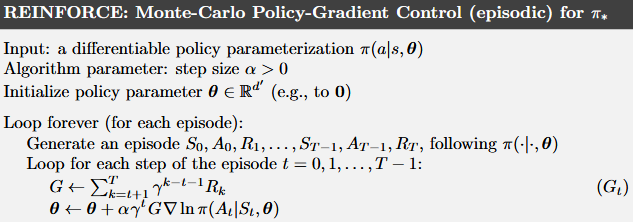

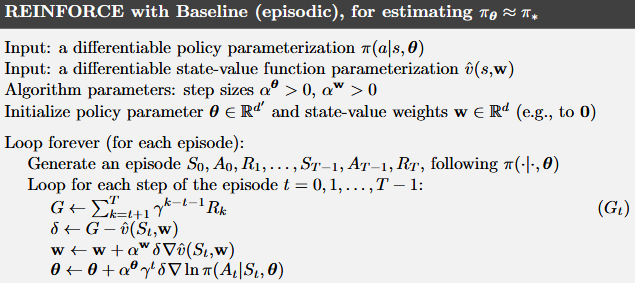

In [ ]:
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
from torch.distributions import Categorical
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

import re
import os
import json                         # to save parameters and results
import time                         # to monitor training & validation time
from datetime import datetime       # to create a log of runs


## Parameter & Class Definition
Define the hyperparameters of the experiment(s), the policy network and value network classes, and the REINFORCE experiment class

In [ ]:
# Hyperparameter definitions
MODEL_NAME = 'Policy_MLP_v1'
ALPHA = 5e-4
BETA = 5e-3
GAMMA = 0.98                    # discount factor for return calculation
N_EPISODE_TRAIN = 5000            # number of episodes to train the Q-network
N_EPISODE_TEST = 5
CUDA_ENABLED = False
SUCCESS_CRITERIA = 450


In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        logits = self.layers[-1](input)
        probs = torch.softmax(logits,dim=-1)
        return probs
    
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[32,32]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        return output

In [ ]:
model_registry = {
    "Policy_MLP_v0": {
        'class': PolicyNet,
        'config': [64,32]
    },
    'Policy_MLP_v1': {
        'class': PolicyNet,
        'config': [64,32],
        'value_class': ValueNet,
        'value_config': [32]
    }
}

In [ ]:
class REINFORCE():
    def __init__(self, model_name: str,
                 model_registry,
                 alpha: float,          # learning rate of the policy net
                 beta: float,           # learning rate of the state value net
                 gamma: float,          # discount rate in RL
                 n_episode_train,
                 result_folder = 'inv_pend_REINFORCE_results',
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.N_EPISODE_TRAIN = n_episode_train
        self.result_folder = result_folder
        self.SEED = seed
        self.CUDA_ENABLED = cuda_enabled
        self.VERBOSE = verbose
        self.LOG_PERIOD = 50

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n
        
        ''' Experiment hyperparameters '''
        # Policy model configuration
        self.model_name = model_name
        self.model_class = model_registry[self.model_name]['class']
        self.model_config = model_registry[self.model_name]['config']
        match = re.search(r'v\d+', self.model_name)
        self.model_id = match.group(0) if match else 404

        # Initialize the policy network
        self.policy_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.policy_net.apply(self.init_weights)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.alpha)

        # REINFORCE w/ baseline => Value model configuration (if value_class exists)
        if 'value_class' in model_registry[self.model_name]:
            if model_registry[self.model_name]['value_class']:
                self.value_class = model_registry[self.model_name]['value_class']
                self.value_config = model_registry[self.model_name]['value_config']
                self.value_net = self.value_class(self.obs_space, 1, self.value_config)
                self.value_net.apply(self.init_weights)
                self.value_optimizer = optim.Adam(self.value_net.parameters(), lr = self.beta)
                self.BASELINE = True
        else: 
            self.BASELINE = False

        self.save_path = ''
        self.model_path = ''
        self.hyperparam_config = ''
        self.reward_history = []
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        
        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: ""}

        hyperparam_codified = "REINFORCE_"
        hyperparam_codified += "baseline_" if self.BASELINE else ""
        hyperparam_codified += "OOP_"
        hyperparam_codified += "CUDA_" if self.CUDA_ENABLED else "nCUDA_"
        hyperparam_codified += f"{self.model_id}_{self.alpha}_"
        hyperparam_codified += f"{self.beta}_" if self.BASELINE else ""
        hyperparam_codified += f"{self.gamma}"

        hyperparam_codified_time = f"{timestamp}_" + hyperparam_codified

        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.CUDA_ENABLED,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_id':             self.model_id,
            'alpha':                self.alpha,
            'gamma':                self.gamma,
        }
        if self.BASELINE: training_params['beta'] = self.beta

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def get_returns(self, eps_reward_history):
        ''' Function to calculate the return of each time step when given a list of rewards 
        
        Parameters:
        ----------
        rewards : list
            a list of rewards achieved throughout the agent's trajectory
        gamma   : float
            the discount factor
        
        Returns:
        ----------
        returns : list
            a list of returns G_t at each step of the trajectory
            
        For each step of th trajectory (of length T):
        - Extract the rewards from that step onward
        - Each step is multiplied by the corresponding gamma ^ index 
            the first reward received from leaving the state is not discounted
            the last reward received from the trajectory is discouned by gamma ^ (T-1)
        - Sum these values together to obtain the return at each step
        '''
        returns = np.zeros(len(eps_reward_history))
        gamma = self.gamma
        
        for step, _ in enumerate(eps_reward_history):          # step through the "trajectory" or history of reward
            step_reward = eps_reward_history[step:]            # reward from the current step onward

            # List of discounted rewards at each time step
            return_val = [gamma ** i * step_reward[i] for i in range(len(step_reward))]
            return_val = sum(return_val)
            
            returns[step] = return_val
        return returns

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = True):
        ''' Assess the average reward when following the policy net in a test environment with random state initialization
        
        Parameters:
        ----------
        env : gymnasium environment
            this environment can be either the self.env_test or self.env_val environment (whether they are the same)
        n_episode_test : int 
            the number of evaluation episodes
        verbose : bool
            whether to print testing information 

        Return:
        ----------
        average_reward : float
            the average reward received from running the test
        '''

        total_reward = 0
        with torch.no_grad():
            for i in range(n_episode_test):
                obs,_ = env.reset()
                done = False
                eps_reward = 0

                while not done:                 # Step thorugh the episode deterministically (no exploration)
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                    action_probs = self.policy_net(obs_tensor)
                    action_dist = Categorical(action_probs)
                    action = action_dist.sample()
                    next_obs, reward, term, trunc, _ = env.step(action.item())

                    # Strategy 1 - Accumulate the reward from the environment
                    eps_reward += reward

                    # TODO - Strategy 2 - evaluate the strategy based on states

                    obs = next_obs
                    done = term or trunc
            
                total_reward += eps_reward
                if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        average_reward = total_reward / n_episode_test
        
        return average_reward
    
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output
    
    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)
        fig, axes = plt.subplots(2,1, figsize=(20,12))
        axes[0].plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        axes[0].plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        axes[0].set_title(f'Total reward per episode - {self.hyperparam_config}')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Reward')
        axes[0].legend()

        n_episodes= len(self.value_history)
        episodes = range(n_episodes)
        axes[1].plot(episodes, self.value_history[:n_episodes], label = "v(s_0)", color = "blue")
        # If using baseline with a value estimation model, plot this as well
        if self.BASELINE: axes[1].plot(episodes, self.value_est_history[:n_episodes], label = r"$\hat v$(s_0)", color = "red")
        axes[1].set_title(f'Return in state s_0 - {self.hyperparam_config}')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('v(s_0)')
        axes[1].legend()

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])

    def train_policy(self):
        msg = "Training ended with no good model found :<"

        # Create the directory to store results
        self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        if self.BASELINE: title = f"REINFORCE baseline model {self.model_name}, alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}" 
        else: title = f"REINFORCE w/o baseline model {self.model_name}, alpha={self.alpha}, gamma={self.gamma}" 
        if self.VERBOSE: print(title)

        self.reward_history = []                # Track the total reward per episode
        self.val_history = {}                   # Reset the validation history
        self.policy_loss_history = []           # History of loss throughout training
        self.value_loss_history = []
        self.value_history = []                 # History of the v(s_0) calculated using G_t throughout training
        if self.BASELINE: self.value_est_history = []             # History of the \hat v(s_0) calculated using the value net (baseline case)
        self.val_time = 0                       # Time used for validation (s)
        episode = 0

        # Control of early stopping
        consecutive_pass_count = 0
        CONSECUTIVE_PASS_LIMIT = 3
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False                # Whether desired performance is met consistently
        train_terminated = False
        

        self.train_time_start = time.time()
        while not train_terminated:             # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.SEED)
            obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
            done = False
            step = 0
            eps_reward_history = []
            log_prob_history = []

            if self.BASELINE:
                obs_history = []
                obs_history.append(obs_tensor)
                

            while not done:                     # Episode level - loop through steps in an episode
                step += 1
                action_probs = self.policy_net(obs_tensor)
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

                next_obs, reward, term, trunc, _ = self.env.step(action.item())

                if self.BASELINE: obs_history.append(obs_tensor)
                eps_reward_history.append(reward)
                log_prob_history.append(action_dist.log_prob(action))
                
                obs_tensor = torch.tensor(next_obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                done = term or trunc
            
            # Post episode calculations - returns, total episode reward, and loss
            returns = self.get_returns(eps_reward_history)
            returns = torch.tensor(returns, dtype = torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')

            if self.BASELINE: 
                obs_history_tensor = torch.stack(obs_history)
                # print(obs_history_tensor.shape)
                baseline_values = self.value_net(obs_history_tensor)[:-1]
                delta = returns.unsqueeze(dim=1) - baseline_values.detach()
                # Find loss of the value function and update parameters
                value_loss = -torch.sum(baseline_values * delta)
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()

                # Find loss of the policy network and update parameters
                policy_loss = - torch.sum(torch.stack(log_prob_history) * delta)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()

            else:
                policy_loss = - torch.sum(torch.stack(log_prob_history) * returns)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()
            
            eps_reward = sum(eps_reward_history)
        

            self.reward_history.append(eps_reward)     # Total reward of episode
            self.policy_loss_history.append(policy_loss)
            self.value_history.append(returns[0])
            if self.BASELINE:
                with torch.no_grad():   # Estimate and store \hat v(s_0)
                    self.value_est_history.append(self.value_net(obs_history[0]).item())

            # Optimize the network parameters
            
            # Periodic data logger
            
            if episode % self.LOG_PERIOD == 0 and self.VERBOSE:
                printout_msg = f"Episode {episode:5d}/{self.N_EPISODE_TRAIN}: Total reward = {eps_reward:5.1f}   |   G_0 = {returns[0]: 5.2f}"
                if self.BASELINE: printout_msg += fr"   |   $\hat v(s_0)$ = {self.value_est_history[-1]:6.2f}" 
                print(printout_msg, end='\r')

            # Early stopping condition
            if eps_reward >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and record the validation time
                self.val_time_start = time.time()
                test_reward = self.policy_eval(self.env_val, 20,verbose=False)
                self.val_time += time.time() - self.val_time_start

                self.val_history[episode] = [eps_reward, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    self.best_model_episode = episode
                    msg = f"Training terminated due to episode limit, best model saved at episode {self.best_model_episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0

            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_episode = episode
                performance_crit = True 
                msg = f"Early termination at episode {self.best_model_episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.N_EPISODE_TRAIN) or (performance_crit)

        self.train_time = time.time() - self.train_time_start

        print(f"\nTotal runtime - {self.train_time:5.2f}")
        print(msg)
        return

    def record(self):
        # Load the best policy net parameter from the experiment
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists use the last one
        self.env_test = gym.make('CartPole-v1')
        print('Testing the best policy network performance')
        average_reward = self.policy_eval(self.env_test, n_episode_test=500, verbose=True)
        print(f"\nValidation average reward {average_reward:4.2f}")

        # Store the validation history and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path, 'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}

        data['runtime'] = self.train_time
        data['valtime'] = self.val_time
        data['best_model_at'] = self.best_model_episode
        data['val_history'] = self.val_history
        data['test_result'] = average_reward

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()

## REINFORCE Training

In [ ]:
REINFORCE_experiment = REINFORCE("Policy_MLP_v1",
                                #  model_name=MODEL_NAME, 
                                 model_registry,
                                 alpha = ALPHA,
                                 beta = BETA,
                                 gamma = GAMMA,
                                #  n_episode_train = N_EPISODE_TRAIN,
                                 n_episode_train = 1000,
                                 seed=42,
                                 cuda_enabled=CUDA_ENABLED,
                                 verbose=True)
REINFORCE_experiment.train_policy()
REINFORCE_experiment.record()

In [ ]:
env_test_visual = gym.make("CartPole-v1", render_mode = "human")

for episode in range(N_EPISODE_TEST):
    obs, _ = env_test_visual.reset()
    done = False

    while not done:
        obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if CUDA_ENABLED else 'cpu')
        with torch.no_grad():       # Inference only
            action_probs = REINFORCE_experiment.policy_net(obs_tensor)
            action_dist = Categorical(action_probs)
            action = action_dist.sample()
        next_obs, reward, term, trunc, _ = env_test_visual.step(action.item())

        obs = next_obs
        done = term or trunc

# Actor-Critic Method
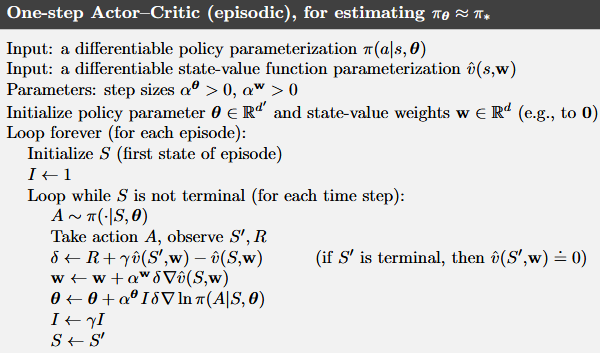

In [ ]:
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
from torch.distributions import Categorical
from torchsummary import summary
import numpy as np
from statistics import mean, stdev

import matplotlib.pyplot as plt

import re
import os
import json                         # to save parameters and results
import time                         # to monitor training & validation time
from datetime import datetime       # to create a log of runs


## Parameter & Class Definition
Define the hyperparameters of the experiment(s), the policy network and value network classes, and the REINFORCE experiment class

In [10]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64,64]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        logits = self.layers[-1](input)
        probs = torch.softmax(logits,dim=-1)
        return probs
    
class ValueNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[32,32]):
        ''' Initialize the model and create a list of layers '''
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for layer_size in hidden_layers:
            self.layers.append(nn.Linear(input_dim, layer_size))
            input_dim = layer_size

        self.layers.append(nn.Linear(input_dim, self.output_dim))
        if CUDA_ENABLED: self.cuda()

    def forward(self, input):
        for layer in self.layers[:-1]:
            input = torch.relu(layer(input))
        output = self.layers[-1](input)
        return output

In [11]:
model_registry = {
    'AC_MLP_v0': {
        'class': PolicyNet,
        'config': [64,32],
        'value_class': ValueNet,
        'value_config': [32]
    }
}

In [22]:
# Hyperparameter definitions
MODEL_NAME = 'AC_MLP_v0'
ALPHA = 1e-4
BETA = 1e-3
GAMMA = 0.98                    # discount factor for return calculation
N_EPISODE_TRAIN = 5000            # number of episodes to train the Q-network
N_EPISODE_TEST = 5
CUDA_ENABLED = False
SUCCESS_CRITERIA = 450


In [30]:
class ActorCritic():
    def __init__(self, model_name: str,
                 model_registry,
                 alpha: float,          # learning rate of the policy net
                 beta: float,           # learning rate of the state value net
                 gamma: float,          # discount rate in RL
                 n_episode_train,
                 result_folder = 'inv_pend_AC_results',
                 seed = 42,
                 cuda_enabled = False,
                 verbose = True):
        
        self.N_EPISODE_TRAIN = n_episode_train
        self.result_folder = result_folder
        self.SEED = seed
        self.CUDA_ENABLED = cuda_enabled
        self.VERBOSE = verbose
        self.LOG_PERIOD = 50

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n
        
        ''' Experiment hyperparameters '''
        # Policy model configuration
        self.model_name = model_name
        match = re.search(r'v\d+', self.model_name)
        self.model_id = match.group(0) if match else 404

        self.policy_model_class = model_registry[self.model_name]['class']
        self.policy_model_config = model_registry[self.model_name]['config']
        self.value_model_class = model_registry[self.model_name]['value_class']
        self.value_model_config = model_registry[self.model_name]['value_config']

        # Instantiate and initialize the policy network
        self.policy_net = self.policy_model_class(self.obs_space, self.act_space, self.policy_model_config)
        self.policy_net.apply(self.init_weights)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.alpha)
        
        # Instantiate and initialize the state value network
        self.value_net = self.value_model_class(self.obs_space, 1, self.value_model_config)
        self.value_net.apply(self.init_weights)
        self.value_optimizer = optim.Adam(self.value_net.parameters(), lr = self.beta)

        self.save_path = ''
        self.model_path = ''
        self.hyperparam_config = ''
        self.reward_history = []
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        
        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = self.result_folder
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: ""}

        hyperparam_codified = "AC_"
        hyperparam_codified += "OOP_"
        hyperparam_codified += "CUDA_" if self.CUDA_ENABLED else "nCUDA_"
        hyperparam_codified += f"{self.model_id}_{self.alpha}_{self.beta}_{self.gamma}"
        hyperparam_codified_time = f"{timestamp}_" + hyperparam_codified

        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'OOP':                  True,
            'CUDA':                 self.CUDA_ENABLED,
            'device':               torch.cuda.get_device_name(torch.cuda.current_device()),
            'model_name':           self.model_name,
            'alpha':                self.alpha,
            'beta':                 self.beta,
            'gamma':                self.gamma,
        }

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def get_returns(self, eps_reward_history):
        ''' Function to calculate the return of each time step when given a list of rewards 
        
        Parameters:
        ----------
        rewards : list
            a list of rewards achieved throughout the agent's trajectory
        gamma   : float
            the discount factor
        
        Returns:
        ----------
        returns : list
            a list of returns G_t at each step of the trajectory
            
        For each step of th trajectory (of length T):
        - Extract the rewards from that step onward
        - Each step is multiplied by the corresponding gamma ^ index 
            the first reward received from leaving the state is not discounted
            the last reward received from the trajectory is discouned by gamma ^ (T-1)
        - Sum these values together to obtain the return at each step
        '''
        returns = np.zeros(len(eps_reward_history))
        gamma = self.gamma
        
        for step, _ in enumerate(eps_reward_history):          # step through the "trajectory" or history of reward
            step_reward = eps_reward_history[step:]            # reward from the current step onward

            # List of discounted rewards at each time step
            return_val = [gamma ** i * step_reward[i] for i in range(len(step_reward))]
            return_val = sum(return_val)
            
            returns[step] = return_val
        return returns

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = True):
        ''' Assess the average reward when following the policy net in a test environment with random state initialization
        
        Parameters:
        ----------
        env : gymnasium environment
            this environment can be either the self.env_test or self.env_val environment (whether they are the same)
        n_episode_test : int 
            the number of evaluation episodes
        verbose : bool
            whether to print testing information 

        Return:
        ----------
        average_reward : float
            the average reward received from running the test
        '''

        reward_history = []
        with torch.no_grad():
            for i in range(n_episode_test):
                obs,_ = env.reset()
                done = False
                eps_reward = 0

                while not done:                 # Step thorugh the episode deterministically (no exploration)
                    obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                    action_probs = self.policy_net(obs_tensor)
                    action_dist = Categorical(action_probs)
                    action = action_dist.sample()
                    next_obs, reward, term, trunc, _ = env.step(action.item())

                    # Strategy 1 - Accumulate the reward from the environment
                    eps_reward += reward

                    # TODO - Strategy 2 - evaluate the strategy based on states

                    obs = next_obs
                    done = term or trunc
            
                reward_history.append(eps_reward)
                if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        reward_mean = mean(reward_history)
        reward_stdev = stdev(reward_history)
        
        return reward_mean, reward_stdev
    
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output
    
    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)
        fig, axes = plt.subplots(2,1, figsize=(20,12))
        axes[0].plot(episodes, self.reward_history[:n_episodes], label = 'Total reward', color = "blue")
        axes[0].plot(episodes, filtered_reward_hist[:n_episodes], label = 'Filtered reward', color = "red")
        axes[0].set_title(f'Total reward per episode - {self.hyperparam_config}')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Reward')
        axes[0].legend()

        n_episodes= len(self.value_history)
        episodes = range(n_episodes)
        axes[1].plot(episodes, self.value_history[:n_episodes], label = "v(s_0)", color = "blue")
        # If using baseline with a value estimation model, plot this as well
        axes[1].plot(episodes, self.value_est_history[:n_episodes], label = r"$\hat v$(s_0)", color = "red")
        axes[1].set_title(f'Return in state s_0 - {self.hyperparam_config}')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('v(s_0)')
        axes[1].legend()

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()

    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.policy_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])

    def train_policy(self):
        msg = "Training ended with no good model found :<"

        # Create the directory to store results
        self.run_number, self.hyperparam_config, self.save_path = self.create_directory()

        # Training information
        title = f"Actor Critic   |   Model {self.model_name}, alpha={self.alpha}, beta={self.beta}, gamma={self.gamma}" 
        if self.VERBOSE: print(title)

        self.reward_history = []                # Track the total reward per episode
        self.val_history = {}                   # Reset the validation history
        self.value_history = []                 # History of the v(s_0) calculated using G_t throughout training
        self.value_est_history = []             # History of the \hat v(s_0) calculated using the value net (baseline case)
        self.val_time = 0                       # Time used for validation (s)
        episode = 0

        # Control of early stopping
        consecutive_pass_count = 0
        CONSECUTIVE_PASS_LIMIT = 3
        EPISODE_REWARD_LIMIT = SUCCESS_CRITERIA
        best_reward = 0
        self.best_model_episode = None
        performance_crit = False                # Whether desired performance is met consistently
        train_terminated = False
        

        self.train_time_start = time.time()
        while not train_terminated:             # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.SEED)
            obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
            obs_init_tensor = obs_tensor
            done = False
            step = 0
            eps_reward_history = []

            while not done:                     # Episode level - loop through steps in an episode
                action_probs = self.policy_net(obs_tensor)
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

                next_obs, reward, term, trunc, _ = self.env.step(action.item())
                done = term or trunc
                current_state_value = self.value_net(obs_tensor)
                next_obs_tensor = torch.tensor(next_obs, dtype = torch.float32, device = 'cuda' if self.CUDA_ENABLED else 'cpu')
                with torch.no_grad():
                    if done: target_state_value = torch.tensor([reward], dtype=torch.float32, device='cuda' if self.CUDA_ENABLED else 'cpu')
                    else: target_state_value = reward + self.gamma * self.value_net(next_obs_tensor)
                delta = target_state_value - current_state_value
                
                # Find and optimize the value loss
                value_loss = nn.MSELoss()(current_state_value, target_state_value)
                # value_loss = delta.pow(2)
                self.value_optimizer.zero_grad()
                value_loss.backward()
                self.value_optimizer.step()
                
                # Find and optimize the policy loss
                policy_loss = - delta.detach() * action_dist.log_prob(action)
                self.optimizer.zero_grad()
                policy_loss.backward()
                self.optimizer.step()

                eps_reward_history.append(reward)
                obs_tensor = next_obs_tensor
                
                step += 1
                
            # print(step)
            # print(f"\nFinal value loss: {value_loss} \nFinal policy loss: {policy_loss}")
            ## Post episode calculations
            # Calculating return state s_0
            returns = self.get_returns(eps_reward_history)
            self.value_history.append(returns[0])

            eps_reward = sum(eps_reward_history)
            self.reward_history.append(eps_reward)     # Total reward of episode
            
            with torch.no_grad():   # Estimate and store \hat v(s_0)
                self.value_est_history.append(self.value_net(obs_init_tensor).item())
            
            # Periodic data logger
            
            if episode % self.LOG_PERIOD == 0 and self.VERBOSE:
                printout_msg = f"Episode {episode:5d}/{self.N_EPISODE_TRAIN}: Total reward = {eps_reward:5.1f}   |   G_0 = {returns[0]: 5.2f}   |   $\hat v(s_0)$ = {self.value_est_history[-1]:6.2f}" 
                print(printout_msg, end='\r')

            # Early stopping condition
            if eps_reward >= EPISODE_REWARD_LIMIT:
                # Evaluate the current good policy and record the validation time
                self.val_time_start = time.time()
                test_reward, _ = self.policy_eval(self.env_val, 20, verbose=False)
                self.val_time += time.time() - self.val_time_start

                self.val_history[episode] = [eps_reward, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    self.best_model_episode = episode
                    msg = f"Training terminated due to episode limit, best model saved at episode {self.best_model_episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0

            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                self.best_model_episode = episode
                performance_crit = True 
                msg = f"Early termination at episode {self.best_model_episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.N_EPISODE_TRAIN) or (performance_crit)

        self.train_time = time.time() - self.train_time_start

        print(f"\nTotal runtime - {self.train_time:5.2f}")
        print(msg)
        return

    def record(self):
        # Load the best policy net parameter from the experiment
        if self.model_path:
            self.load_model()

        # Average test reward of the resulting policy - if best policy does not exists use the last one
        self.env_test = gym.make('CartPole-v1')
        print('Testing the best policy network performance')
        reward_mean, reward_stdev = self.policy_eval(self.env_test, n_episode_test=500, verbose=True)
        print(f"\nValidation average reward {reward_mean:4.2f} (SD = {reward_stdev:4.2f})")

        # Store the validation history and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path, 'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}

        data['runtime'] = self.train_time
        data['valtime'] = self.val_time
        data['best_model_at'] = self.best_model_episode
        data['val_history'] = self.val_history
        data['test_result'] = [reward_mean, reward_stdev]

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()

## Actor-Critic Training


Actor Critic   |   Model AC_MLP_v0, alpha=0.0001, beta=0.001, gamma=0.98
Episode   800/2500: Total reward = 250.0   |   G_0 =  49.68   |   $\hat v(s_0)$ =  51.29
Total runtime - 144.53
Early termination at episode   841, desired performance reached
Testing the best policy network performance
Validation episode 500/500  |   Reward =  394
Validation average reward 478.23 (SD = 40.99)


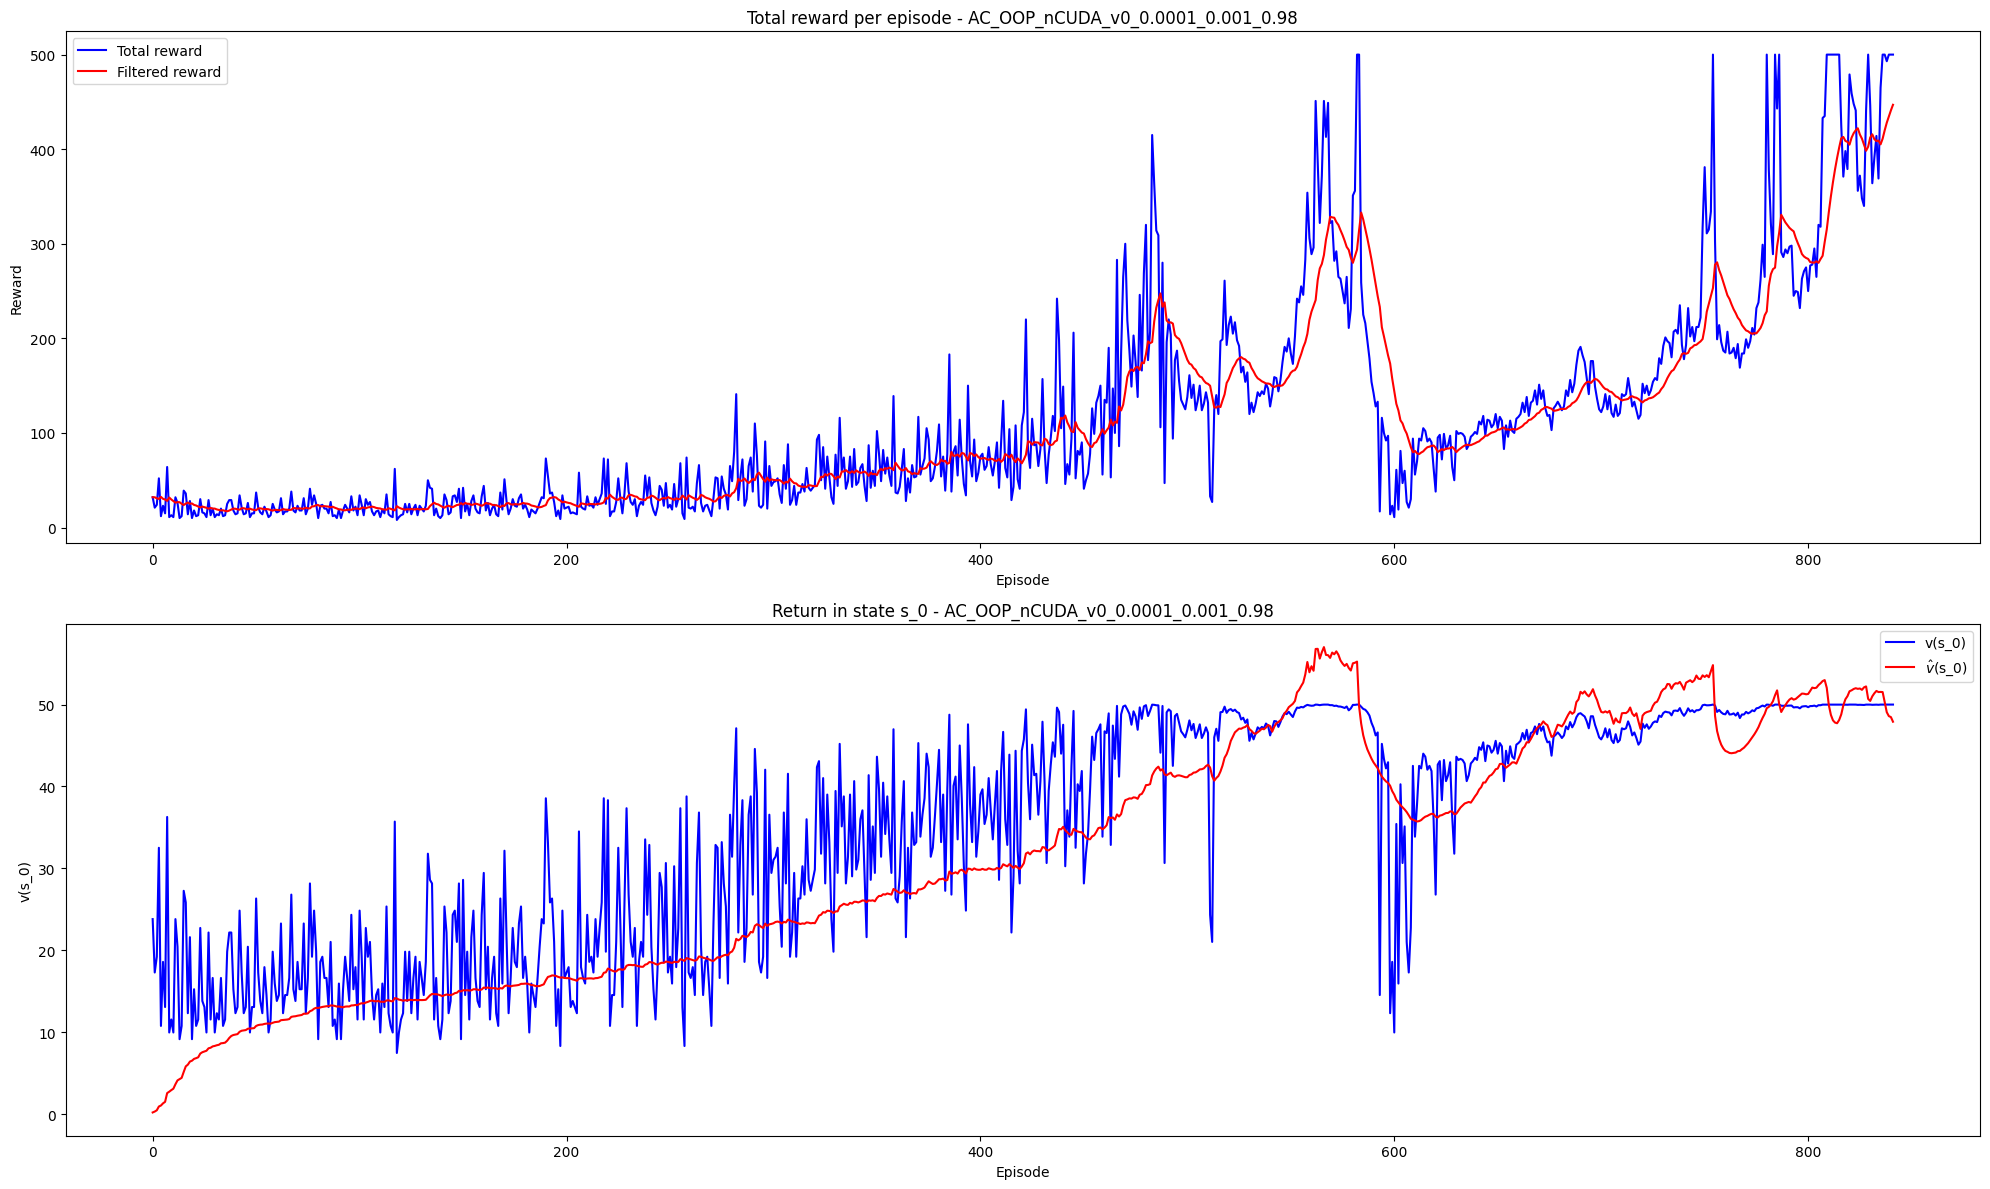

In [31]:
AC_experiment = ActorCritic("AC_MLP_v0",
                            model_registry,
                            alpha = ALPHA,
                            beta = BETA,
                            gamma = GAMMA,
                            n_episode_train = 2500,
                            seed = 42,
                            cuda_enabled = CUDA_ENABLED,
                            verbose = True)
AC_experiment.train_policy()
AC_experiment.record()

In [16]:
env_test = gym.make("CartPole-v1", render_mode = "human")

# print(type(obs))
for episode in range(5):
    obs, _ = env_test.reset()
    done = False
    eps_reward = 0

    while not done:
        obs_tensor = torch.tensor(obs, dtype = torch.float32, device = 'cuda' if CUDA_ENABLED else 'cpu')
        with torch.no_grad():       # Doing inference so no need to track operations
            action_probs = AC_experiment.policy_net(obs_tensor)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()

        next_obs, reward, term, trunc, _ = env_test.step(action.item())

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

Reward from episode   0 is 500.0
Reward from episode   1 is 500.0
Reward from episode   2 is 500.0
Reward from episode   3 is 500.0
Reward from episode   4 is 229.0
